In [ ]:
import tensorflow as tf
print(tf.__version__)
import warnings
warnings.filterwarnings('ignore')

2.7.0


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
#모델은 단계 1,2,3 에서 구현한 모델로 하였습니다.

In [ ]:

from keras import layers 
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',name = 'check'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax', name = 'last'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 check (Conv2D)              (None, 10, 10, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                    

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 12s 11ms/step - loss: 0.1796 - accuracy: 0.9439
Epoch 2/5
938/938 [==============================] - 10s 11ms/step - loss: 0.0460 - accuracy: 0.9858
Epoch 3/5
938/938 [==============================] - 10s 10ms/step - loss: 0.0318 - accuracy: 0.9905
Epoch 4/5
938/938 [==============================] - 10s 11ms/step - loss: 0.0241 - accuracy: 0.9924
Epoch 5/5
938/938 [==============================] - 10s 10ms/step - loss: 0.0195 - accuracy: 0.9940


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

313/313 [==============================] - 2s 5ms/step - loss: 0.0203 - accuracy: 0.9933


0.9933000206947327

<IPython.core.display.Javascript object>

Saved to photo.jpg


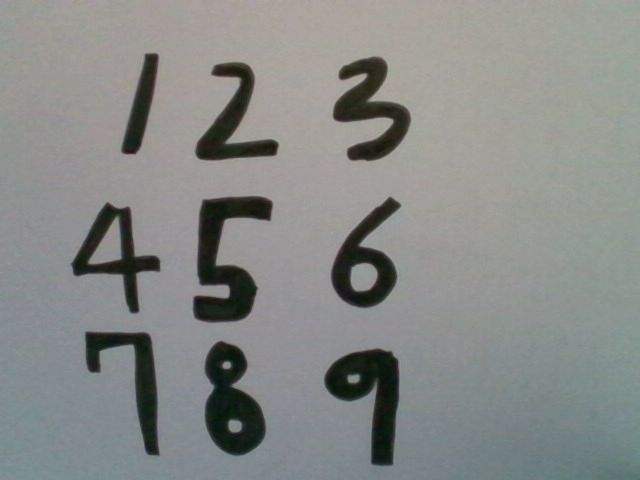

In [ ]:
from IPython.display import Image

filename = take_photo()
print('Saved to {}'.format(filename))
  
display(Image(filename))

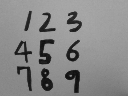

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline
src = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

#이미지의 크기가 워낙 크기 때문에 5분의1로 줄여서 확인을 합니다.

src = cv2.resize(src , (int(src.shape[1]/5),int(src.shape[0]/5)))
cv2_imshow(src)


In [ ]:
#양 옆의 노이즈를 제거합니다.(만약 노이즈가 없다거나 사진을 다시찍을 경우 이 코드는 필요가 없습니다.)
src = src[1:src.shape[0]-5, 10:src.shape[1]-38] 

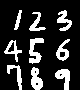

In [ ]:


#영상 이진화를 해줍니다.(사람마다 카메라의 상태가 다르기 때문에 필요시 보정이 필요합니다.)
ret , binary = cv2.threshold(src,105,255,cv2.THRESH_BINARY_INV) 

cv2_imshow(binary)

In [ ]:
contours , hierarchy = cv2.findContours(binary , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE) #외곽선 검출 을 해줍니다.
color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR) #이진화 이미지를 color이미지로 복사를 해줍니다.(확인용)
cv2.drawContours(color , contours , -1 , (0,255,0),3) #초록색으로 외곽선을 그려줍니다.

#리스트연산을 위해 초기변수 선언해줍니다.
bR_arr = []
digit_arr = []
digit_arr2 = []
count = 0 
#검출한 외곽선에 사각형을 그려서 배열에 추가해줍니다.
for i in range(len(contours)) : 
  bin_tmp = binary.copy() 
  x,y,w,h = cv2.boundingRect(contours[i]) 
  bR_arr.append([x,y,w,h])


In [ ]:
# 사각형을 만들어서 손글씨를 나누어 주었지만 배열을 확인해보면 랜덤하게 박스가 생성되었다는 것을 알 수 있습니다.
print(bR_arr[:5])

[[55, 69, 15, 21], [31, 67, 12, 23], [7, 65, 15, 25], [4, 40, 18, 22], [56, 39, 14, 22]]


In [ ]:
#x값을 기준으로 배열을 정렬을 합니다.
bR_arr = sorted(bR_arr, key=lambda num : num[0], reverse = False)
print(bR_arr[:5])


[[4, 40, 18, 22], [7, 65, 15, 25], [14, 10, 8, 20], [29, 38, 15, 26], [29, 12, 17, 19]]


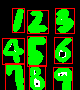

In [ ]:
#작은 노이즈데이터 버림,사각형그리기,12개씩 리스트로 다시 묶어서 저장을 해줍니다.

for x,y,w,h in bR_arr :
  tmp_y = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[0]
  tmp_x = bin_tmp[y-2:y+h+2,x-2:x+w+2].shape[1]
  if  tmp_x and tmp_y > 10 :
    count += 1 
    cv2.rectangle(color,(x-2,y-2),(x+w+2,y+h+2),(0,0,255),1) 
    digit_arr.append(bin_tmp[y-2:y+h+2,x-2:x+w+2]) 
    if count == 12 : 
      digit_arr2.append(digit_arr) 
      digit_arr = [] 
      count = 0 
cv2_imshow(color) 


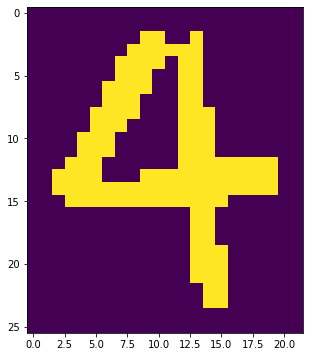

In [ ]:
# digit_arr[0]에 들어가있는 사진을 확인해봅니다.
plt.figure(figsize=(8,6))
plt.imshow(digit_arr[0]);

In [ ]:
from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions
count = 0
nrows = 3
ncols = 4
for n in digit_arr:
    img = cv2.resize(n,(28,28))
    cv2_imshow(img)
    img = img.reshape((-1,28,28,1))
    
    x = np.array(img)
    x = preprocess_input(x)
    
    preds = model.predict(x)
    print('Predicted:', np.argmax(preds, axis=-1))
    

Predicted: [4]


Predicted: [2]


Predicted: [1]


Predicted: [5]


Predicted: [2]


Predicted: [2]


Predicted: [9]


Predicted: [6]


Predicted: [3]


아쉽게도 숫자예측이 100%일치하지 않았습니다. img를 봤을때는 mode.predict에 입력이 잘 들어간 것 같지만 웹캠 카메라 특성상 빛번짐 또는 화질 때문에 제대로 인식이 안됐거나 img = cv2.resize(n,(28,28)) 이후 전처리 과정에서 데이터 손실이 난 것 같습니다. 그래도 9개중 2~3개를 제외하고 숫자를 잘 예측을 한다는 면에서는 긍정적인 것 같습니다.